# House Prices: Advanced Regression Techniques

## Estimating house prices

I applied the XGBoost machine learning technique and to the data. As for feature engineering, I replaced missing data with the most frequent value/category in each column, removed outliers (any prices above 450k) and did one-hot-encoding on the categorical values.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Downloading and Preparing the Train data

In [9]:
input_file = "Train_2.csv"
df_train=pd.read_csv(input_file)
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_train.shape # There are 1460 houses with 81 features for each

(1460, 81)

### How much data is missing?
Let's check for any "gaps" in the data.

In [11]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


The features **PoolQC, MiscFeature, Alley** and **Fence** are dropped since they are missing between 81 and 99.5% of the data. Trying to replace such a large amount of missing data artificially would probably lead to biases.  <br>
Also the feature 'Id' is dropped, since it carries no value for the training model.

In [12]:
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence','Id'], axis=1)

In [13]:
df_train.shape # now the nr of features os down to 76

(1460, 76)

### Spotting and removing outliers
Plotting the 'SalePrice' in a histogram makes it clear that outliers are present!  Looks like any prices above c. 450k could be deleted.

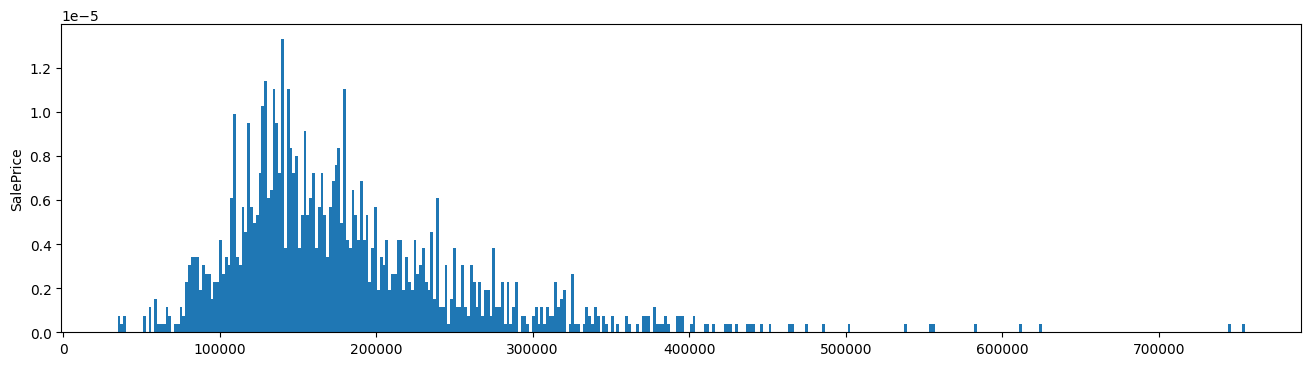

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

x =df_train['SalePrice']
plt.hist(x, density=True, bins=400)
plt.ylabel('SalePrice');

We remove the outliers using a function, which leaves out the 'SalePrice' where the value is larger than 450.000.

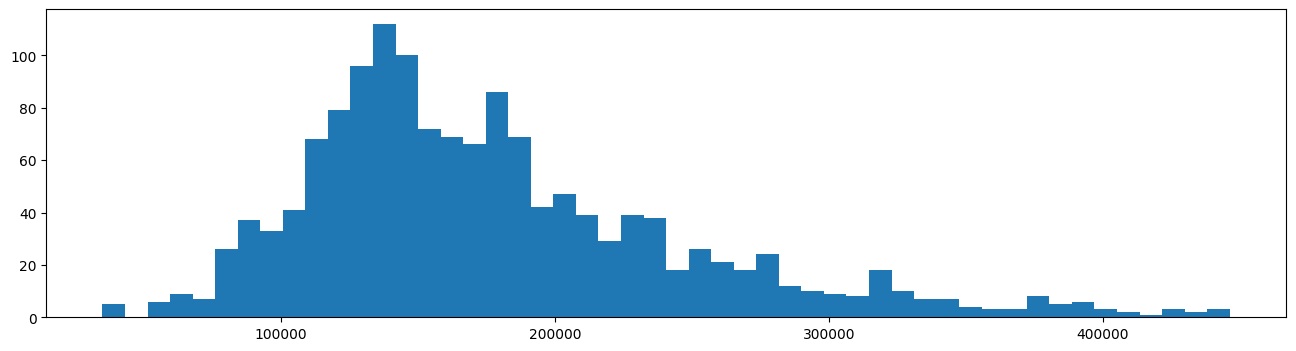

(1446, 1)

In [16]:
def reject_outliers(SalePrice):
    filtered= [e for e in (df_train['SalePrice']) if (e < 450000)]
    return filtered

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

filtered = reject_outliers('SalePrice')
plt.hist(filtered, 50)
fig_size[0]=16.0
fig_size[1]=8.0
plt.show()

df_no_outliers = pd.DataFrame(filtered)
df_no_outliers.shape

This will mean that 14 samples (=1460-1446) will be removed. Let's create  the new dataframe.

In [17]:
df_train = df_train[df_train['SalePrice']<450000]

In [18]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


### Dropping also 'SalePrice' from the df to create X-train

In [19]:
X_train = df_train.drop(['SalePrice'], axis=1)

In [20]:
X_train.shape

(1446, 75)

### Creating the Y-labels, i.e. 'SalePrice'

In [21]:
Y_labels = df_train['SalePrice']

In [22]:
Y_labels.shape

(1446,)

Remaining *categorical* values are found as 'Objects':

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1446 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1446 non-null   int64  
 1   MSZoning       1446 non-null   object 
 2   LotFrontage    1188 non-null   float64
 3   LotArea        1446 non-null   int64  
 4   Street         1446 non-null   object 
 5   LotShape       1446 non-null   object 
 6   LandContour    1446 non-null   object 
 7   Utilities      1446 non-null   object 
 8   LotConfig      1446 non-null   object 
 9   LandSlope      1446 non-null   object 
 10  Neighborhood   1446 non-null   object 
 11  Condition1     1446 non-null   object 
 12  Condition2     1446 non-null   object 
 13  BldgType       1446 non-null   object 
 14  HouseStyle     1446 non-null   object 
 15  OverallQual    1446 non-null   int64  
 16  OverallCond    1446 non-null   int64  
 17  YearBuilt      1446 non-null   int64  
 18  YearRemodAdd 

In [25]:
# 39 categorical values remain, the rest are numerical. These are the categrocial values:
cat_values= ['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition']

To fill the gaps for these missing CATEGORICAL DATA and NUMERICAL DATA is replaced with their most_frequent value in each category.

In [26]:
X_train = X_train.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every numercial column with its own most frequent value

X_train = X_train.fillna(X_train['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
X_train = X_train.fillna(X_train['BsmtQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageType'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageQual'].value_counts().index[0])
X_train = X_train.fillna(X_train['GarageCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtCond'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtExposure'].value_counts().index[0])
X_train = X_train.fillna(X_train['BsmtFinType1'].value_counts().index[0])
X_train = X_train.fillna(X_train['FireplaceQu'].value_counts().index[0])

#### Missing data now replaced by their mean or with categories by the most frequent value in each column.
### Next, using ScikitLearn's OneHotEncoder to handle text and categorical attributes.

# Enconding Categorical Data


In [27]:
X_train = pd.get_dummies(X_train, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])

# NO NEED TO CREATE NEW DF, ONE-HOT-COLUMNS AUTOMATICALLY REPLACING CATEGORICAL COLUMNS!!!!

In [28]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1446.000000,1446.000000,1446.000000,1446.00000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1446.000000,1446.000000,1446.00000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,56.995159,67.996542,10426.825726,6.06639,5.577455,1971.030429,1984.684647,98.945367,436.552559,46.627248,...,469.369295,93.262794,45.937759,22.166667,3.44260,14.527663,2.401798,43.910097,6.331950,2007.815353
std,42.446131,22.138085,9927.254968,1.34695,1.113250,30.114667,20.654418,171.659401,446.360566,161.520020,...,211.343642,124.484376,65.723213,61.376116,29.45708,54.448467,37.664404,498.502039,2.704688,1.326258
min,20.000000,21.000000,1300.000000,1.00000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7500.000000,5.00000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,...,326.250000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,63.000000,9434.500000,6.00000,5.000000,1972.000000,1993.000000,0.000000,380.500000,0.000000,...,478.000000,0.000000,24.000000,0.000000,0.00000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.000000,11494.500000,7.00000,6.000000,2000.000000,2004.000000,160.000000,703.500000,0.000000,...,576.000000,168.000000,66.000000,0.000000,0.00000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.00000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.00000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Over 200 new columns/"features" added through one-hot-encoding!<br>

The following were missing in Test data after the the one-hot-encoding conversion, therefore they will be dropped from Train data in order to keep Train and Test data "equal".

In [29]:
X_train = X_train.drop(['Condition2_RRAe','Exterior2nd_Other','Condition2_RRAn','Condition2_RRNn','HouseStyle_2.5Fin','RoofMatl_ClyTile','RoofMatl_Membran','RoofMatl_Metal','RoofMatl_Roll','Exterior1st_ImStucc','Heating_Floor','Heating_OthW','Electrical_Mix','GarageQual_Ex', 'Exterior1st_Stone','Utilities_NoSeWa'], axis=1)
# 'ElectrecialUnf' was moved...

In [30]:
X_train.shape

(1446, 258)

## Read and Preparing the Test data

In [33]:
input_file = "Test_2.csv"

df_test=pd.read_csv(input_file)

In [34]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [35]:
df_test.shape

(1459, 80)

### How much data is missing?
Same check as for the Train data.

In [36]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
MasVnrType,894,0.612748
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageQual,78,0.053461
GarageCond,78,0.053461
GarageFinish,78,0.053461


Dropping the features PoolQC, MiscFeature, Alley and Fence since they are missing between 80% and 99.5% of the data.

In [37]:
df_test = df_test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [38]:
df_test.shape

(1459, 76)

Replace missing CATEGORICAL and NUMERICAL DATA with their most_frequent value in each catgeory.

In [39]:
df_test = df_test.apply(lambda x:x.fillna(x.value_counts().index[0])) #= fills every column with its own most frequent value

df_test = df_test.fillna(df_test['GarageFinish'].value_counts().index[0]) #fill NaNs with the most frequent value from that column.
df_test = df_test.fillna(df_test['BsmtQual'].value_counts().index[0])
df_test = df_test.fillna(df_test['FireplaceQu'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageType'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageQual'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageCond'].value_counts().index[0])
df_test = df_test.fillna(df_test['GarageFinish'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtCond'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtExposure'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtFinType1'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtFinType2'].value_counts().index[0])
df_test = df_test.fillna(df_test['BsmtUnfSF'].value_counts().index[0])


Next, enconding Categorical Test Data.

In [40]:
df_test = pd.get_dummies(df_test, columns=['FireplaceQu','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition'])


In [41]:
df_test.shape

(1459, 259)

In [42]:
df_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0,468,...,False,False,False,True,False,False,False,False,True,False
1,1462,20,81.0,14267,6,6,1958,1958,108,923,...,False,False,False,True,False,False,False,False,True,False
2,1463,60,74.0,13830,5,5,1997,1998,0,791,...,False,False,False,True,False,False,False,False,True,False
3,1464,60,78.0,9978,6,6,1998,1998,20,602,...,False,False,False,True,False,False,False,False,True,False
4,1465,120,43.0,5005,8,5,1992,1992,0,263,...,False,False,False,True,False,False,False,False,True,False


In [43]:
# Removing the feature 'Id' before implementing the model
X_test = df_test.drop(['Id'], axis=1)

In [44]:
X_test.shape

(1459, 258)

### XGBoost - regressor
I'm using Extreme Gradient Boosting.

In [45]:
from xgboost import XGBRegressor

In [46]:
xgb_clf = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_clf.fit(X_train, Y_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#### Accuracy after cross validation with X_train
The results from this code was mainly used for guidance while training the model and checking for possible improvements after each feature engineering session. Please note, this code uses cross validation (higher is better), not RMSE (lower is better), as in the actual competition

In [47]:
from sklearn.model_selection import cross_val_score

xgb_clf_cv = cross_val_score(xgb_clf,X_train, Y_labels, cv=10, ) # .911240390855695

print(xgb_clf_cv.mean())

0.8896283447742462


### Making predictions with the model

In [48]:
xgb_clf = XGBRegressor(n_estimators=1000, learning_rate=0.05)

xgb_clf.fit(X_train, Y_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
xgb_predictions_test = xgb_clf.predict(X_test) # shape(1459, 262)

xgb_predictions_test

array([130392.664, 161715.44 , 190805.17 , ..., 151995.48 , 118052.63 ,
       211886.92 ], dtype=float32)

In [50]:
xgb_predictions_test.shape # (1459,)

(1459,)

## Submission file to kaggle.com

In [54]:
# Create a new dataframe with only the columns Kaggle wants from the data set!
submission = pd.DataFrame({
        "Id": df_test["Id"],
        "SalePrice": xgb_predictions_test
    })

submission.to_csv("kaggleXGB_HousePrices.csv", index=False)
#creates a csv-file that can be uploaded here
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit

There are several ways to improve the dataset, such as creating new features by combining existing ones. In any case, here are a few insights I gained while working with the data and the model:
- Perform feature engineering on the combined Train and Test sets to avoid duplicating work and to ensure consistent preprocessing. Once the transformations are complete, you can split them back into separate sets.
- One‑hot encoding generally works better for XGBoost than standard label encoding. It also expands the feature space significantly, which can be helpful but may become unwieldy if the original dataset already contains many features.
- When one‑hot encoding is applied separately to Train and Test sets, it often results in mismatched columns. You may need to remove or align certain newly created columns to ensure both sets have the same structure.



#### Checking for correlations and feature importances
Some features/variables are more impiortant, and perhaps removing the less significant ones might improve the results?

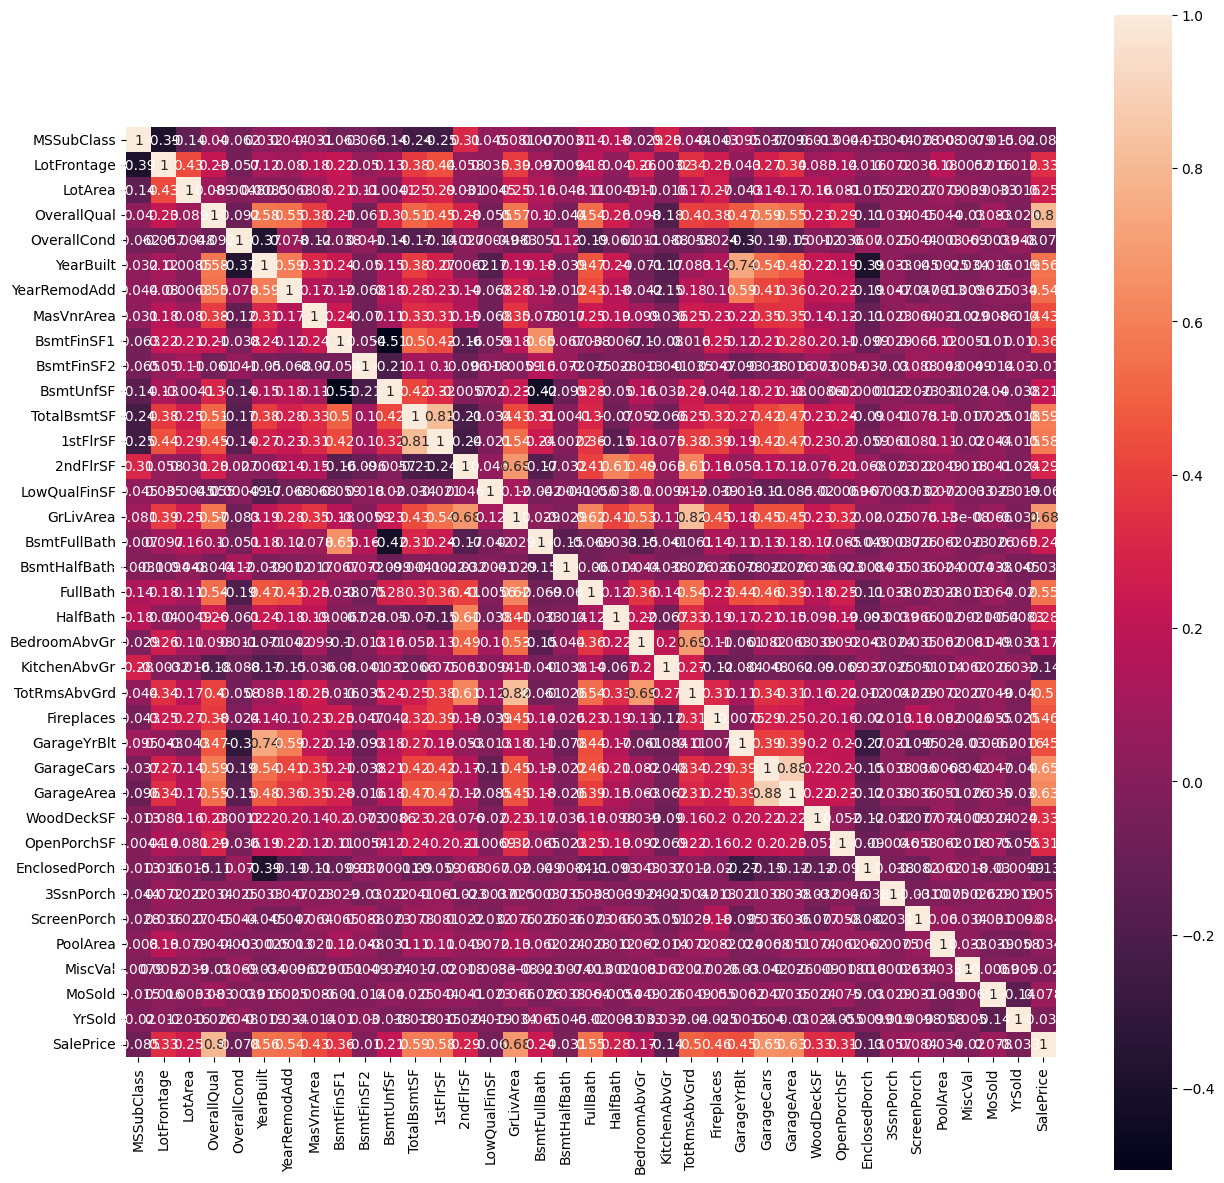

In [56]:
# NOTE!! This one is with df_train, i.e. SalePrice  still included, but before One-Hot-Encoding!!
import seaborn as sns
corr_matrix = df_train.select_dtypes(include=[np.number]).corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

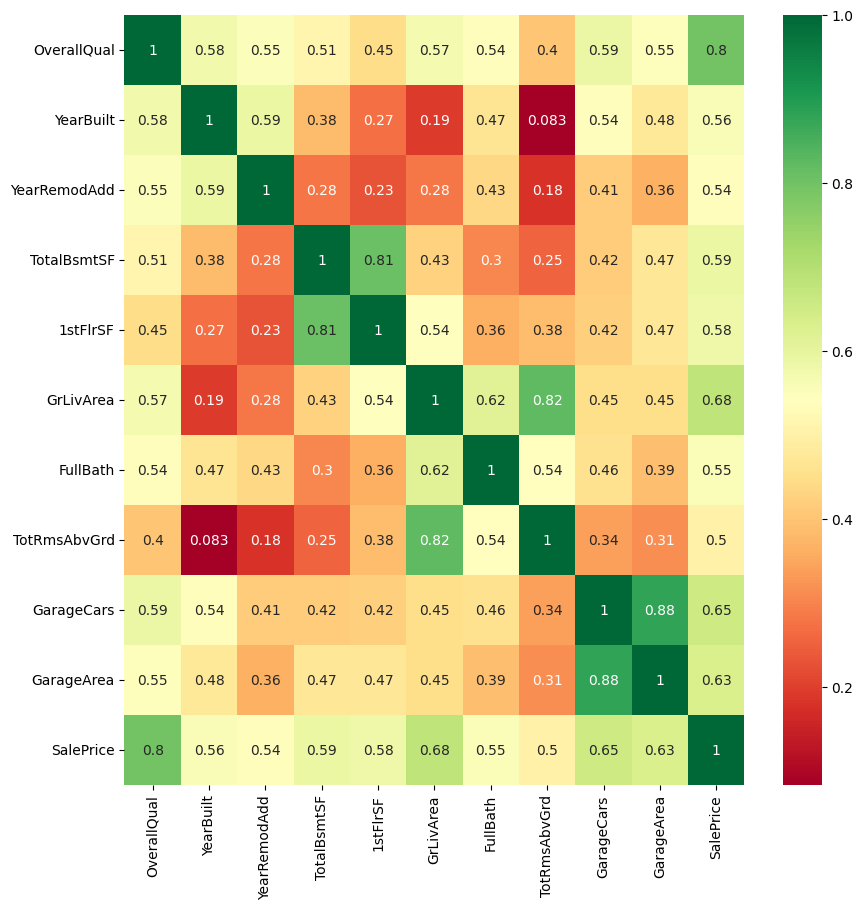

In [60]:
#Most correlated features:
corr_matrix = df_train.select_dtypes(include=[np.number]).corr()
top_corr_features = corr_matrix.index[abs(corr_matrix['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# NOTE!! This one is with df_train, i.e. SalePrice still included, but before One-Hot-Encoding!!!!

### Checking for feature importance
Checking for the relative importance of each attribute for making accurate predictions.

[2.33901112e-04 8.99582577e-04 2.37011770e-03 2.46429518e-01
 4.51404322e-03 3.11954506e-03 2.62999139e-03 8.47848423e-04
 7.01523805e-03 1.00662198e-03 1.07661029e-03 1.17829209e-02
 6.56833686e-03 2.99557066e-03 3.87965731e-04 2.93768663e-02
 3.17201181e-03 1.48899388e-03 2.44673691e-03 2.07784772e-03
 2.54120748e-03 2.12279968e-02 7.14554684e-04 1.03935525e-02
 1.02325110e-03 9.53897014e-02 2.61416147e-03 1.47585792e-03
 1.64285279e-03 7.89214566e-04 1.92068968e-04 1.37916184e-03
 2.62566231e-04 3.03367560e-04 1.07882021e-03 3.98635573e-04
 7.91633101e-06 3.70512396e-04 3.33285541e-03 2.98626744e-03
 4.99014626e-04 2.82145268e-03 1.24909845e-03 4.15132614e-04
 4.65639820e-03 2.16458142e-02 0.00000000e+00 0.00000000e+00
 1.57005398e-03 2.54686136e-04 7.66064113e-05 4.53647738e-03
 8.83983099e-04 2.39833118e-03 3.78730154e-04 2.30646948e-03
 0.00000000e+00 6.32673502e-04 8.81270447e-04 1.39634218e-03
 1.78668415e-04 2.48148164e-04 7.76771642e-03 6.58110762e-03
 0.00000000e+00 1.733590

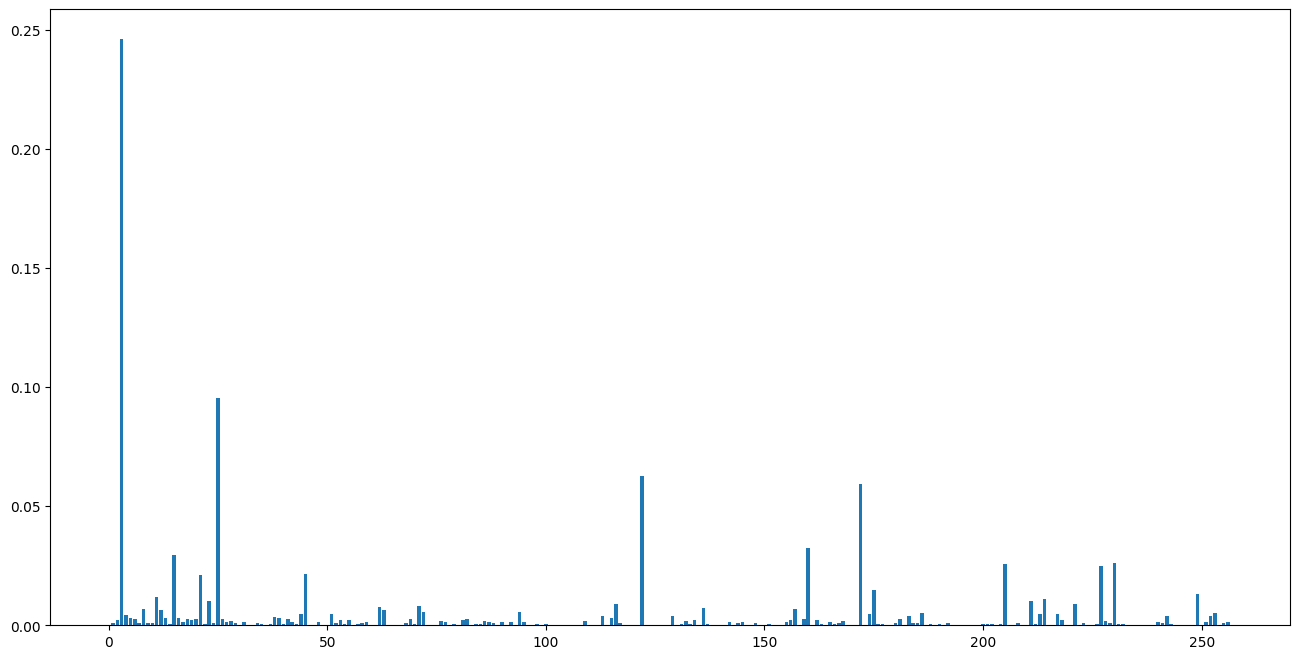

In [61]:
# feature importance
print(xgb_clf.feature_importances_)
from matplotlib import pyplot
# plot
f, ax = plt.subplots(figsize=(16, 8))
pyplot.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
pyplot.show()

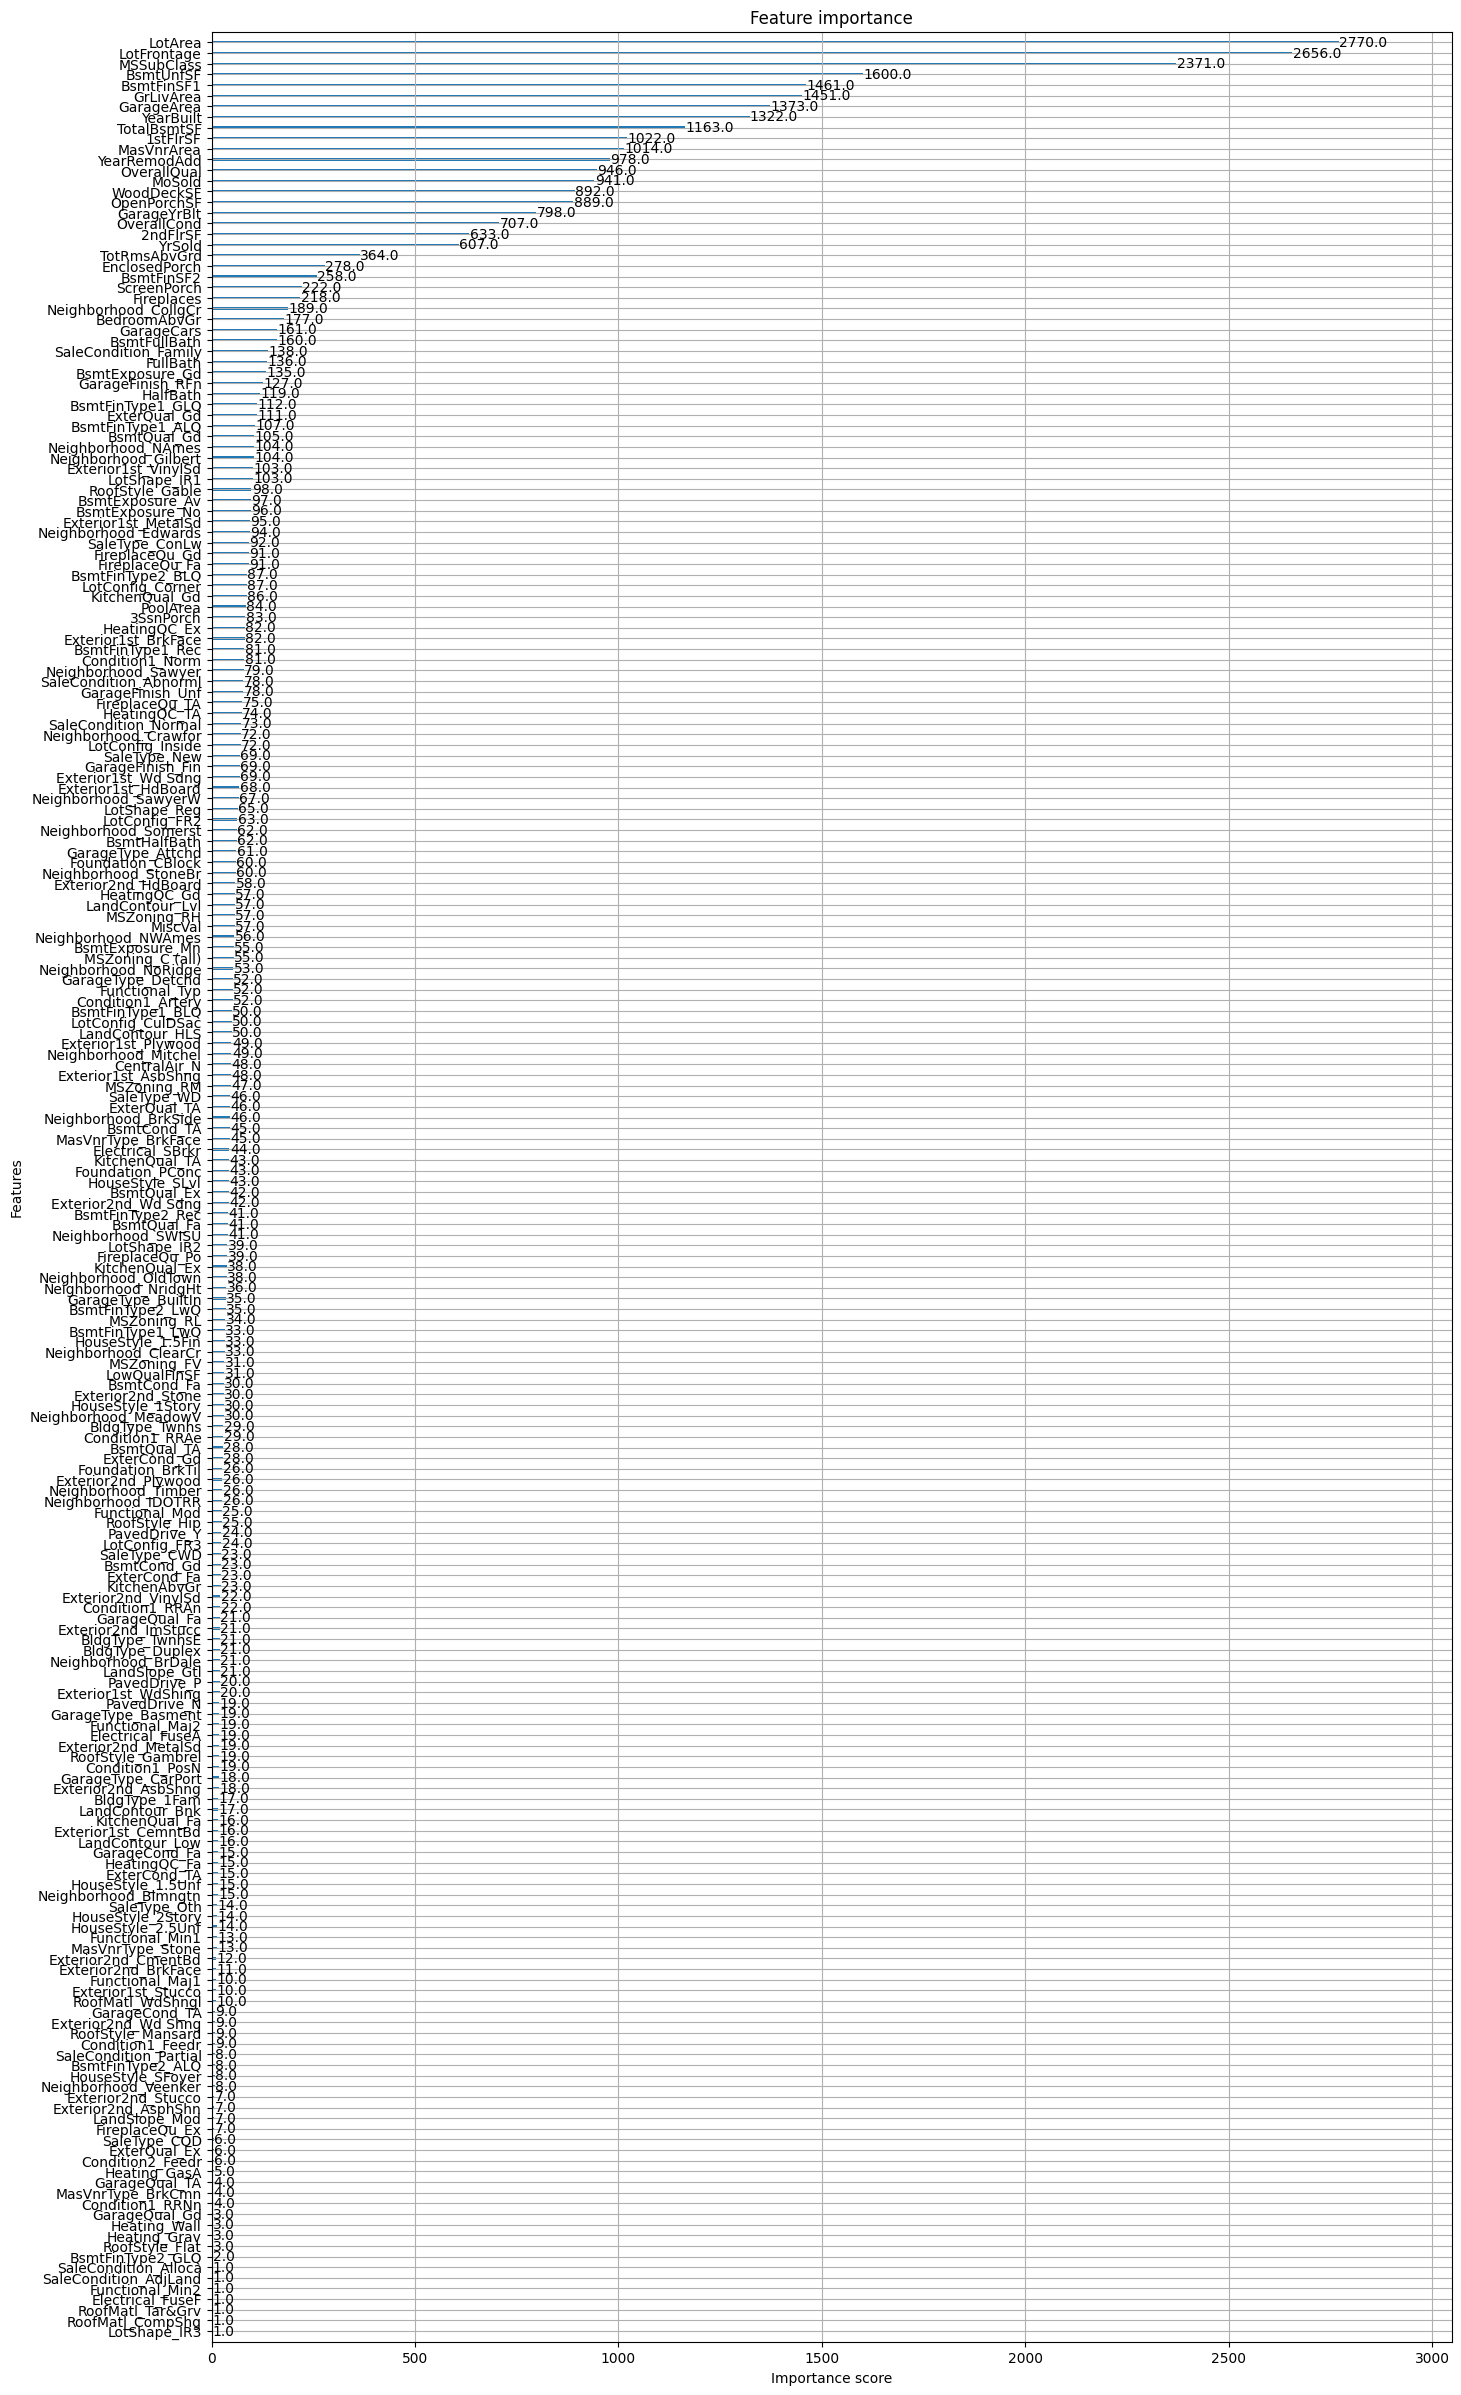

In [62]:
# plot feature importance using a built-in function in XGBoost
from xgboost import plot_importance
fig_size = plt.rcParams["figure.figsize"]
fig_size[0]=16.0
fig_size[1]=30.0 # from King County House Prices
plot_importance(xgb_clf)
pyplot.show()

### Findings
The chart reveals which features most strongly influence the model’s predictions. The top contributors are:
- LotArea (3770.0): The size of the lot is the most influential feature, suggesting that larger properties tend to have higher predicted values.
- OverallQual (2656.0): The overall material and finish quality of the house is a major driver of value.
- GrLivArea (2371.0): Above-ground living area square footage is highly predictive, reinforcing the importance of usable space.
- TotalBsmtSF (1600.0) and GarageCars (1461.0): Basement size and garage capacity also play significant roles.
Many other features have low or zero importance scores, indicating they contribute little to the model’s performance and may be candidates for removal or consolidation


Conclusion
- Focus on the top features (LotArea, OverallQual, GrLivArea) for model interpretability and potential dimensionality reduction.
- Streamline preprocessing by combining Train and Test sets before feature engineering.
- Use one-hot encoding with caution—while powerful, it can introduce complexity and misalignment if not handled carefully.
- Consider pruning low-importance features to reduce noise and improve model efficiency.
Would you like help visualizing the feature reduction impact or aligning the encoded columns programmatically?
